In [1]:
import librosa
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import os
from torch.utils.data import DataLoader, Dataset

from pydub import AudioSegment
import soundfile as sf

import matplotlib.pyplot as plt
import librosa.display
import random
import torchaudio

import matplotlib.pyplot as plt
import torchaudio
import torchaudio.transforms as T
import os
from tqdm import tqdm
import torch.cuda.amp as amp

In [2]:
def mu_law_encode(x, mu=255):
    """x: FloatTensor in [-1, 1] → LongTensor in [0, mu]"""
    mu = float(mu)
    safe_x = torch.clamp(x, -1.0, 1.0)
    x_mu = (
        torch.sign(safe_x)
        * torch.log1p(mu * torch.abs(safe_x))
        / torch.log1p(torch.tensor(mu, device=x.device))
    )
    encoded = ((x_mu + 1) / 2 * mu).round().clamp(0, mu).long()
    return encoded


def mu_law_decode(encoded, mu=255):
    """encoded: LongTensor in [0, mu] → FloatTensor in [-1, 1]"""
    mu = float(mu)
    # Map from [0, mu] → [-1, 1]
    x = encoded.float() / mu * 2 - 1
    # Invert mu-law companding
    mag = (1.0 / mu) * ((1.0 + mu) ** torch.abs(x) - 1.0)
    decoded = torch.sign(x) * mag
    return decoded


In [3]:



class SegmentedWaveformDataset(Dataset):
    def __init__(
        self,
        wav_dir,
        sample_rate=16000,
        segment_duration=3.0,
        overlap=0.5,
        mu_law=True,
        preload=True,
    ):
        self.sample_rate = sample_rate
        self.segment_samples = int(segment_duration * sample_rate)
        self.step_size = int(self.segment_samples * (1 - overlap))
        self.mu_law = mu_law
        self.preload = preload

        self.wav_paths = [
            os.path.join(wav_dir, f) for f in os.listdir(wav_dir) if f.endswith(".wav")
        ]
        self.wavs = []

        print("🔍 Scanning and segmenting WAV files...")
        self.index = []  # (file_idx, offset)

        for i, path in enumerate(self.wav_paths):
            wav, sr = torchaudio.load(path)
            wav = wav.mean(dim=0)  # mono

            if sr != sample_rate:
                wav = torchaudio.functional.resample(wav, sr, sample_rate)

            if self.preload:
                self.wavs.append(wav)

            num_segments = max(
                0, (wav.size(0) - self.segment_samples) // self.step_size + 1
            )
            for j in range(num_segments):
                offset = j * self.step_size
                self.index.append((i, offset))

        print(
            f"✅ Indexed {len(self.index)} segments from {len(self.wav_paths)} files."
        )

    def __len__(self):
        return len(self.index)

    def __getitem__(self, idx):
        file_idx, offset = self.index[idx]

        if self.preload:
            wav = self.wavs[file_idx]
        else:
            wav, sr = torchaudio.load(self.wav_paths[file_idx])
            wav = wav.mean(dim=0)
            if sr != self.sample_rate:
                wav = torchaudio.functional.resample(wav, sr, self.sample_rate)

        segment = wav[offset : offset + self.segment_samples]

        # Pad final segment
        if segment.size(0) < self.segment_samples:
            segment = F.pad(segment, (0, self.segment_samples - segment.size(0)))

        # Normalize to [-1, 1]
        max_val = segment.abs().max()
        if max_val > 1e-6:
            segment = segment / max_val
        else:
            segment = torch.zeros_like(segment)

        if self.mu_law:
            encoded = mu_law_encode(segment).long().squeeze()  # 🔧 Ensure (T,)
            return encoded, segment
        else:
            return segment, segment

    def get_raw(self, idx):
        file_idx, offset = self.index[idx]
        wav, sr = torchaudio.load(self.wav_paths[file_idx])
        wav = wav.mean(dim=0)

        if sr != self.sample_rate:
            wav = torchaudio.functional.resample(wav, sr, self.sample_rate)

        segment = wav[offset : offset + self.segment_samples]
        if segment.size(0) < self.segment_samples:
            segment = F.pad(segment, (0, self.segment_samples - segment.size(0)))

        max_val = segment.abs().max()
        return segment / max_val if max_val > 0 else torch.zeros_like(segment)

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, residual_channels, skip_channels, dilation, cond_channels=None):
        super().__init__()
        self.dilation = dilation

        self.filter_conv = nn.Conv1d(
            residual_channels,
            residual_channels,
            kernel_size=2,
            dilation=dilation,
            padding=0,
        )
        self.gate_conv = nn.Conv1d(
            residual_channels,
            residual_channels,
            kernel_size=2,
            dilation=dilation,
            padding=0,
        )
        self.res_conv = nn.Conv1d(residual_channels, residual_channels, kernel_size=1)
        self.skip_conv = nn.Conv1d(residual_channels, skip_channels, kernel_size=1)

        if cond_channels is not None:
            self.cond_proj_filter = nn.Conv1d(
                cond_channels, residual_channels, kernel_size=1
            )
            self.cond_proj_gate = nn.Conv1d(
                cond_channels, residual_channels, kernel_size=1
            )
        else:
            self.cond_proj_filter = None
            self.cond_proj_gate = None

    def forward(self, x, z=None):
        pad = self.dilation
        x_padded = F.pad(x, (pad, 0))  # causal pad left side

        f = self.filter_conv(x_padded)
        g = self.gate_conv(x_padded)

        if z is not None:
            if z.size(2) != f.size(2):
                z = z[:, :, -f.size(2) :]
            f += self.cond_proj_filter(z)
            g += self.cond_proj_gate(z)

        out = torch.tanh(f) * torch.sigmoid(g)

        res = self.res_conv(out)
        skip = self.skip_conv(out)

        # Align input with output in time dimension (res may be shorter)
        x = x[:, :, -res.size(2) :]
        return x + res, skip


class WaveNet(nn.Module):
    def __init__(
        self,
        in_channels=256,
        residual_channels=64,
        skip_channels=128,
        dilation_cycles=2,
        layers_per_cycle=10,
        embed_dim=64,
        cond_channels=None,
    ):
        super().__init__()
        self.receptive_field = self.compute_receptive_field(
            layers_per_cycle, dilation_cycles, kernel_size=2
        )

        self.embedding = nn.Embedding(in_channels, embed_dim)
        self.input_proj = nn.Conv1d(embed_dim, residual_channels, kernel_size=1)

        self.res_blocks = nn.ModuleList()
        for _ in range(dilation_cycles):
            for layer in range(layers_per_cycle):
                dilation = 2**layer
                self.res_blocks.append(
                    ResidualBlock(
                        residual_channels,
                        skip_channels,
                        dilation,
                        cond_channels=cond_channels,
                    )
                )

        self.output = nn.Sequential(
            nn.ReLU(),
            nn.Conv1d(skip_channels, skip_channels, kernel_size=1),
            nn.ReLU(),
            nn.Conv1d(skip_channels, in_channels, kernel_size=1),
        )

    def forward(self, x, z=None):
        # Expect input shape: [B, T] or [B, 1, T]
        if x.dim() == 3 and x.size(1) == 1:
            x = x.squeeze(1)
        elif x.dim() != 2:
            raise ValueError(f"Expected input shape [B, T] or [B, 1, T], got {x.shape}")

        x = self.embedding(x).permute(0, 2, 1)  # [B, embed_dim, T]
        x = self.input_proj(x)  # [B, residual_channels, T]

        skip_connections = []
        for block in self.res_blocks:
            x, skip = block(x, z)
            skip_connections.append(skip)

        # Align all skip connections to the shortest time dim
        min_len = min(s.size(2) for s in skip_connections)
        skip_connections = [s[:, :, -min_len:] for s in skip_connections]
        skip_sum = sum(skip_connections)

        return self.output(skip_sum)

    @staticmethod
    def compute_receptive_field(layers_per_cycle, dilation_cycles, kernel_size=2):
        return (
            sum([(kernel_size - 1) * (2**i) for i in range(layers_per_cycle)])
            * dilation_cycles
            + 1
        )

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🖥️ Using device: {device}")

# Initialize dataset
dataset = SegmentedWaveformDataset(
    wav_dir="data3",
    sample_rate=16000,
    segment_duration=3.0,  # 🔧 fixed arg name
    overlap=0.5,
    preload=True,
    mu_law=True,
)

# Use a reasonable number of workers unless you're on a monster box
dataloader = DataLoader(
    dataset,
    batch_size=2,
    shuffle=True,
    num_workers=32,  # 🔧 tuned for most modern CPUs
    pin_memory=True,
)

🖥️ Using device: cuda
🔍 Scanning and segmenting WAV files...
✅ Indexed 289 segments from 4 files.


In [6]:
def visualize_reconstruction_live(model, waveform, step, z=None, sample_rate=16000):
    model.eval()
    with torch.no_grad():
        waveform = waveform.unsqueeze(0).to(model.embedding.weight.device)  # (1, T)
        print("Original waveform stats:")
        print(" → min:", waveform.min().item())
        print(" → max:", waveform.max().item())
        print(" → mean:", waveform.mean().item())
        print(" → std:", waveform.std().item())

        # Encode input
        x = mu_law_encode(waveform).long()
        x_input = x[:, :-1]  # (B, T-1)
        x_target = x[:, 1:]

        # Optional conditioning
        if z is not None:
            z = z.to(x_input.device)
            z_up = F.interpolate(z, size=x_input.size(1), mode="nearest")
        else:
            z_up = None

        # Predict and decode
        y_pred = model(x_input, z=z_up)  # (B, 256, T-1)
        y_class = torch.argmax(y_pred, dim=1)  # (B, T-1)
        decoded = mu_law_decode(y_class.squeeze(0).cpu().detach())  # (T-1,)

    # Decode original for fair comparison
    original_decoded = mu_law_decode(mu_law_encode(waveform.squeeze(0).cpu()))
    original_decoded = original_decoded[: decoded.size(0)]  # match length

    # Plot waveform
    plt.figure(figsize=(12, 4))
    plt.plot(original_decoded[:1000], label="Original", alpha=0.7)
    plt.plot(decoded[:1000], label="Decoded", alpha=0.7)
    plt.title(f"Waveform Comparison @ Step {step}")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Plot Mel spectrograms
    spec_transform = T.MelSpectrogram(
        sample_rate=sample_rate, n_fft=1024, hop_length=256, n_mels=80
    )
    original_spec = spec_transform(original_decoded.unsqueeze(0))[0]
    decoded_spec = spec_transform(decoded.unsqueeze(0))[0]

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(original_spec.log2().numpy(), origin="lower", aspect="auto")
    plt.title("Original Mel")

    plt.subplot(1, 2, 2)
    plt.imshow(decoded_spec.log2().numpy(), origin="lower", aspect="auto")
    plt.title("Decoded Mel")

    plt.suptitle(f"Mel Spectrogram @ Step {step}")
    plt.tight_layout()
    plt.show()


In [ ]:

# --- Config ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🖥️ Using device: {device}")

use_conditioning = False
z_dim = 64

model = WaveNet(
    in_channels=256,
    residual_channels=64,
    skip_channels=128,
    dilation_cycles=2,
    layers_per_cycle=8,
    embed_dim=64,
    cond_channels=z_dim if use_conditioning else None,
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
scaler = amp.GradScaler()

num_epochs = 200
max_steps = 100_000
step = 1
best_loss = float("inf")

pbar = tqdm(total=max_steps, desc="Training", dynamic_ncols=True)
os.makedirs("checkpoints", exist_ok=True)

for epoch in range(1, num_epochs + 1):
    for batch in dataloader:
        if step > max_steps:
            break

        # --- Unpack Batch ---
        if use_conditioning:
            encoded, raw = zip(*batch)
            waveform = torch.stack(raw).to(device)
            z = torch.stack(encoded).to(device)
        else:
            waveform = torch.stack(batch).to(device)
            z = None

        # --- Drop extra channels (stereo → mono) ---
        if waveform.dim() == 3 and waveform.size(1) > 1:
            waveform = waveform[:, 0, :]  # (B, T)
        elif waveform.dim() == 3 and waveform.size(1) == 1:
            waveform = waveform.squeeze(1)  # (B, T)

        # --- Mu-law Encoding ---
        x = mu_law_encode(waveform).long()  # (B, T)

        # Sanity check — avoid short segments
        if x.size(1) < 2:
            print(f"⚠️ Skipping batch with short segment at step {step}")
            continue

        x_input = x[:, :-1].to(device)
        x_target = x[:, 1:].to(device)

        # --- Conditioning ---
        z_up = (
            F.interpolate(z, size=x_input.size(1), mode="nearest")
            if use_conditioning
            else None
        )

        optimizer.zero_grad()

        with amp.autocast():
            y_pred = model(x_input, z=z_up)

            # Shape check
            if y_pred.shape[2] != x_target.shape[1]:
                print(
                    f"❌ Shape mismatch: y_pred {y_pred.shape}, target {x_target.shape}"
                )
                continue

            loss = F.cross_entropy(y_pred, x_target)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # --- Logging ---
        pbar.update(1)
        pbar.set_description(f"Epoch {epoch} | Step {step}")
        pbar.set_postfix(
            loss=f"{loss.item():.4f}",
            gpu=f"{torch.cuda.memory_allocated() / 1e6:.1f} MB",
        )

        # --- Checkpointing ---
        if step % 5000 == 0:
            print(f"[Epoch {epoch} | Step {step}] Loss: {loss.item():.4f}")

        if step % 10000 == 0:
            torch.save(model.state_dict(), f"checkpoints/model_step{step}.pt")

        if loss.item() < best_loss and step % 50000 == 0:
            best_loss = loss.item()
            torch.save(model.state_dict(), "checkpoints/best_model.pt")

        if step % 2500 == 0:
            try:
                idx = random.randint(0, len(dataset) - 1)
                sample_wave = dataset.get_raw(idx)
                visualize_reconstruction_live(model, sample_wave, step)
            except Exception as e:
                print(f"[Warning] Visualization failed at step {step}: {e}")

        step += 1

    if step > max_steps:
        print(f"\n✅ Max steps {max_steps} reached.")
        torch.save(model.state_dict(), "checkpoints/last_model.pt")
        break

pbar.close()

🖥️ Using device: cuda


/tmp/ipykernel_403371/1651663699.py:26: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = amp.GradScaler()
Training:   0%|          | 0/100000 [00:00<?, ?it/s]/tmp/ipykernel_403371/1651663699.py:76: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
Epoch 1 | Step 5:   0%|          | 5/100000 [00:02<11:01:58,  2.52it/s, gpu=59.2 MB, loss=5.4527]

Epoch 35 | Step 5000:   5%|▌         | 5000/100000 [25:21<7:52:24,  3.35it/s, gpu=59.2 MB, loss=1.2332] 

[Epoch 35 | Step 5000] Loss: 1.2332


Epoch 69 | Step 10000:  10%|█         | 10000/100000 [51:49<7:25:32,  3.37it/s, gpu=59.2 MB, loss=1.1497]

[Epoch 69 | Step 10000] Loss: 1.1497


Epoch 104 | Step 15000:  15%|█▌        | 15000/100000 [1:17:11<7:00:31,  3.37it/s, gpu=59.2 MB, loss=1.1525] 

[Epoch 104 | Step 15000] Loss: 1.1525


Epoch 138 | Step 20000:  20%|██        | 20000/100000 [1:42:32<6:35:43,  3.37it/s, gpu=59.2 MB, loss=0.9157] 

[Epoch 138 | Step 20000] Loss: 0.9157


Epoch 173 | Step 25000:  25%|██▌       | 25000/100000 [2:07:55<6:12:20,  3.36it/s, gpu=59.2 MB, loss=1.0262] 

[Epoch 173 | Step 25000] Loss: 1.0262


Epoch 200 | Step 29000:  29%|██▉       | 29000/100000 [2:28:11<6:02:48,  3.26it/s, gpu=58.8 MB, loss=1.1849] 


In [17]:
def top_k_logits(logits, k=30):
    """Apply top-k filtering to logits."""
    topk_vals, _ = torch.topk(logits, k)
    min_topk = topk_vals[:, -1].unsqueeze(-1)
    return torch.where(
        logits < min_topk, torch.full_like(logits, float("-inf")), logits
    )

def upsample_z(z, target_len):
    """
    Nearest-neighbor upsampling of encoder latents Z to audio sample rate.
    
    Args:
        z: Tensor (1, D, T_z)
        target_len: int, target time length (samples)
        
    Returns:
        Tensor (1, D, target_len)
    """
    return F.interpolate(z, size=target_len, mode='nearest')


def generate(model, seed, steps=16000, temperature=1.0, top_k=None):
    """
    Generate waveform from an unconditional WaveNet decoder.

    Args:
        model: WaveNet model (must support forward(x))
        seed: FloatTensor in [-1, 1], shape (T,)
        steps: int, number of new samples to generate
        temperature: float, softmax temperature
        top_k: int, optional top-k sampling

    Returns:
        FloatTensor waveform (1D)
    """
    model.eval()
    device = next(model.parameters()).device

    # Encode seed to mu-law tokens
    x = mu_law_encode(seed).long().to(device).unsqueeze(0)  # (1, T)

    # Pad seed if shorter than receptive field
    if x.size(1) < model.receptive_field:
        pad = model.receptive_field - x.size(1)
        x = F.pad(x, (pad, 0), value=127)  # 127 = mid token

    output = x.squeeze(0).tolist()

    with torch.no_grad():
        for i in range(steps):
            x_input = x[:, -model.receptive_field :]  # (1, receptive_field)

            y = model(x_input)  # (1, 256, receptive_field)
            logits = y[:, :, -1] / temperature  # (1, 256)

            if top_k:
                logits = top_k_logits(logits, k=top_k)

            probs = F.softmax(logits, dim=-1)  # (1, 256)
            sample = torch.multinomial(probs, num_samples=1)  # (1, 1)
            token = sample.item()
            output.append(token)

            # Update x with the new sample
            x = torch.cat([x, sample], dim=1)

    # Decode mu-law tokens to waveform
    output_tensor = torch.tensor(output, dtype=torch.long)
    return mu_law_decode(output_tensor.cpu())  # (T,)

In [19]:
seed_waveform = dataset.get_raw(0)
seed = seed_waveform[: model.receptive_field]

generated_wave = generate(model, seed, steps=960_000)
torchaudio.save("generated_1min.wav", generated_wave.unsqueeze(0), 16000)

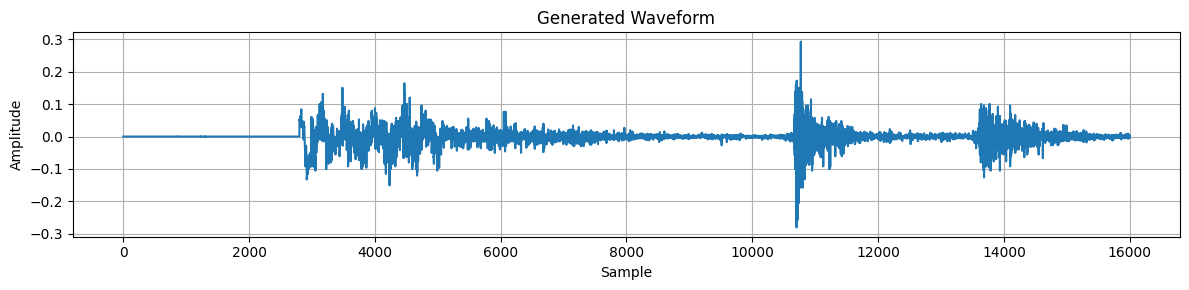

In [20]:
import torchaudio
import matplotlib.pyplot as plt

# Load the generated waveform
waveform, sr = torchaudio.load("generated_1min.wav")

# Plot first 2 seconds for readability
plt.figure(figsize=(12, 3))
plt.plot(waveform[0, : sr].cpu().numpy())
plt.title("Generated Waveform")
plt.xlabel("Sample")
plt.ylabel("Amplitude")
plt.grid(True)
plt.tight_layout()
plt.show()